In [21]:
%matplotlib inline

import os
import glob
import json
import time
import copy
import pickle
import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import log_loss
from PIL import Image, ImageDraw
import bcolz

import config
import utils

In [2]:
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [46]:
def csv_predictions_to_array(path):
    frame = pd.read_csv(path)
    d = {}
    for index, row in frame.iterrows():
        d[row['image']] = np.array(row[:-1], dtype=np.float32)
    return np.array([d[k] for k in sorted(d)])


def create_rect_xywh(box, color='red'):
    return plt.Rectangle((box[0], box[1]), box[2], box[3],
                         color=color, fill=False, linewidth=2)


def plot(img):
    x = copy.copy(img)
    x = x + max(-np.min(x), 0)
    x_max = np.max(x)
    if x_max != 0:
        x /= x_max
    x *= 255
    plt.imshow(np.array(x, dtype=np.uint8))


def show_test(model, i):
    prediction = model.predict(np.expand_dims(X_test_feat[i], axis=0))
    p = prediction[0][0]
    box_pred_tl = prediction[1][0]
    box_pred_wh = prediction[2][0]
    plt.figure(figsize=(9, 12))
    plot(X_test[i])
    ax = plt.gca()
    print('Id: ', Id_test[i])
    print('Class: {}, p: {}'.format(classes[np.argmax(p)], p[np.argmax(p)]))
    box_pred = []
    box_pred.extend(box_pred_tl)
    box_pred.extend(box_pred_wh)
    print('Box (x,y,w,h): ', box_pred)
    if box_pred_wh[0] > 0 and box_pred_wh[1] > 0:
        ax.add_patch(create_rect_xywh(box_pred, 'yellow'))

In [47]:
info_string = 'fish'
index = 0
prefix = os.path.join('cache', info_string + '_' + str(index))

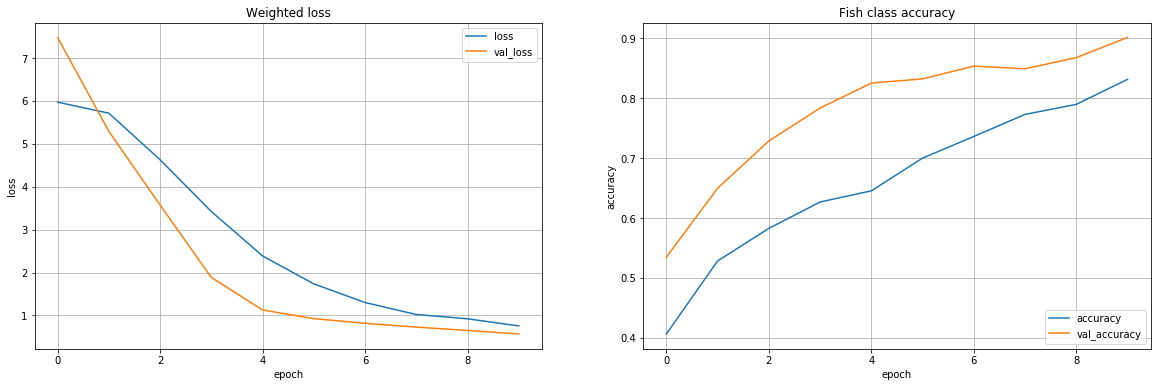

In [48]:
history = pickle.load(open(prefix + '_history.p', 'rb'))

plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.title('Weighted loss')
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.subplot(122)
plt.title('Fish class accuracy')
plt.plot(history['class_acc'], label='accuracy')
plt.plot(history['val_class_acc'], label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.show()

In [49]:
test = csv_predictions_to_array('test_stg1.csv')
pred = csv_predictions_to_array(os.path.join('cache', 'fish_0_2017-02-03-17-13.csv'))

diff = 0
for i in range(len(test)):
    if np.argmax(test[i]) != np.argmax(pred[i]):
        diff += 1

print('Diff:', diff)
print('Log loss:', log_loss(test, pred))

Diff: 351
Log loss: 1.25309362684


In [17]:
from keras.models import model_from_json
model = model_from_json(open(prefix + '.json', 'r').read())

X_test = utils.load_array('X_test.bcolz')
Id_test = utils.load_array('Id_test.bcolz')
X_test_feat = utils.load_array('X_test_feat.bcolz')
print(np.shape(X_test))
print(np.shape(X_test_feat))
print(np.shape(Id_test))

Using TensorFlow backend.


(1000, 448, 448, 3)
(1000, 14, 14, 512)
(1000,)


Id:  img_00071.jpg
Class: YFT, p: 1.0
Box (x,y,w,h):  [-3.0123703, 15.182611, -34.523186, 22.998106]


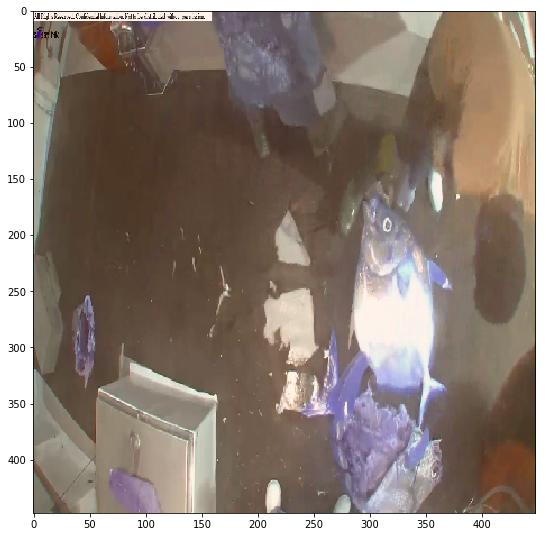

In [39]:
sorted_ids = np.argsort(Id_test)
show_test(model, sorted_ids[9])

In [50]:
temp = {}
for i in range(len(classes)):
    temp[classes[i]] = 0

for i in range(len(X_test)):
    for j in range(len(classes)):
        temp[classes[j]] += pred[i][j] # model.predict(np.expand_dims(X_test_feat[i], axis=0))[0][0][j]
print(temp)

{'BET': 42.426104978061517, 'ALB': 455.93833972132086, 'LAG': 33.360227878517584, 'NoF': 134.36561488774066, 'OTHER': 133.18141003414181, 'YFT': 169.12714009478731, 'SHARK': 13.383583555930763, 'DOL': 18.217577841098436}


In [398]:
frame = pd.read_csv('test_stg1.csv')
img_name = frame['image']
label = frame.loc[:, classes]
labeldict = {}

for i in range(len(frame)):
    labeldict[img_name[i]] = np.argmax(np.array(label.iloc[i]))

c_matrix=np.zeros([10,10])
for i in range(len(img_name)):
    predicted = np.argmax(model.predict(np.expand_dims(X_test_feat[i], axis=0))[0][0])
    truelabel = labeldict[Id_test[i]] 
    print(predicted,' ', truelabel)
    c_matrix[predicted][truelabel]+=1
    

print(c_matrix)

0   5
1   1
7   7
0   0
4   4
7   3
1   5
4   4
0   5
7   1
0   0
0   0
7   7
0   0
0   0
0   0
0   1
0   7
0   0
0   0
0   0
0   7
0   0
0   0
0   0
4   4
7   1
0   0
0   0
0   0
0   0
0   0
4   4
0   0
7   7
0   0
0   7
5   3
0   0
0   0
0   7
7   5
0   6
0   4
0   0
1   6
0   0
7   7
7   7
0   0
0   0
6   7
7   7
0   0
7   2
0   0
0   0
0   0
0   0
7   5
0   1
0   0
0   0
7   7
0   0
0   0
0   5
0   0
0   7
0   0
0   0
7   7
0   0
0   0
7   2
4   4
0   0
0   1
0   0
0   0
5   5
0   0
0   0
4   4
0   5
0   0
4   0
4   4
0   5
0   0
0   0
4   4
4   0
0   5
0   0
0   0
0   0
0   0
0   0
0   0
4   0
4   4
0   0
0   0
0   0
4   4
7   7
0   0
0   0
0   0
4   4
0   0
0   0
1   0
0   0
0   0
0   0
4   4
0   0
0   0
6   6
0   0
5   5
0   0
1   6
0   0
2   7
1   7
0   0
0   0
0   0
0   0
0   0
4   4
4   4
0   0
7   7
0   7
0   0
0   0
0   5
4   4
0   0
0   0
0   0
7   7
0   0
0   0
0   0
0   0
1   7
1   3
1   6
0   0
0   0
0   7
4   4
0   0
0   0
0   5
5   5
0   0
0   0
4   4
0   0
0   0
0   